# Sentiment Analysis for Mental Health: Detecting Depression and Anxiety Using NLP

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


True

## Data Preprocessing

In [ ]:
# Load dataset 
df = pd.read_csv("Combined Data.csv")

# Define a function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = word_tokenize(text)  # Tokenize words
    words = [w for w in words if w not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatization
    return ' '.join(words)

# Handle missing values in 'statement' column
df['statement'] = df['statement'].fillna('')

# Apply preprocessing
df['clean_text'] = df['statement'].apply(preprocess_text)

# Convert categorical labels into numeric values
df['status'] = df['status'].map({'Normal': 0, 'Depression': 1, 'Anxiety': 2})


print("Data preprocessing completed!")


Data preprocessing completed!


In [8]:
# Drop NaN values
df = df.dropna(subset=['statement', 'status'])

In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['status'], test_size=0.2, random_state=42)

## Feature Extraction (TF-IDF and Word2Vec)

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF transformation completed!")


TF-IDF transformation completed!


In [11]:
from gensim.models import Word2Vec

# Tokenize the text for Word2Vec
tokenized_train = [text.split() for text in X_train]
tokenized_test = [text.split() for text in X_test]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

# Function to convert text into vector representation
def vectorize_text(text, model, vector_size=100):
    words = text.split()
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model:
            vector += model[word]
            count += 1
    return vector / count if count > 0 else vector

X_train_w2v = np.array([vectorize_text(text, word_vectors) for text in X_train])
X_test_w2v = np.array([vectorize_text(text, word_vectors) for text in X_test])

print("Word2Vec transformation completed!")


Word2Vec transformation completed!


## Model Training (Logistic Regression, Naïve Bayes, SVM, and LSTM)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Train Logistic Regression on TF-IDF
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Train Naïve Bayes on TF-IDF
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# Train SVM on TF-IDF
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression F1-score:", f1_score(y_test, y_pred_lr, average='macro'))

print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naïve Bayes F1-score:", f1_score(y_test, y_pred_nb, average='macro'))

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM F1-score:", f1_score(y_test, y_pred_svm, average='macro'))


Logistic Regression Accuracy: 0.9106466545097489
Logistic Regression F1-score: 0.8726285793735605
Naïve Bayes Accuracy: 0.8388273250105204
Naïve Bayes F1-score: 0.8045664084722768
SVM Accuracy: 0.9172394445223734
SVM F1-score: 0.8870726487579658


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizing the text for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM Model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate LSTM Model
y_pred_lstm = model.predict(X_test_pad).argmax(axis=1)
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM F1-score:", f1_score(y_test, y_pred_lstm, average='macro'))


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 94s 101ms/step - accuracy: 0.7235 - loss: 0.6762 - val_accuracy: 0.8920 - val_loss: 0.2968
Epoch 2/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 89s 100ms/step - accuracy: 0.9173 - loss: 0.2486 - val_accuracy: 0.9154 - val_loss: 0.2398
Epoch 3/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 89s 100ms/step - accuracy: 0.9379 - loss: 0.1904 - val_accuracy: 0.9142 - val_loss: 0.2734
Epoch 4/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 91s 102ms/step - accuracy: 0.9538 - loss: 0.1472 - val_accuracy: 0.9129 - val_loss: 0.2638
Epoch 5/5
892/892 ━━━━━━━━━━━━━━━━━━━━ 90s 101ms/step - accuracy: 0.9629 - loss: 0.1246 - val_accuracy: 0.9154 - val_loss: 0.2829
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
LSTM Accuracy: 0.9154159068593071
LSTM F1-score: 0.8863861885141041


Below is a refined version of building the LSTM model with changes & improvements as follows:
Dropout increased (0.5 & 0.3) to prevent overfitting
L2 Regularization (l2(0.001)) to reduce complexity
Early Stopping (patience=3) to stop training when validation loss stops improving
Reduce Learning Rate (ReduceLROnPlateau) for better convergence

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define the improved LSTM model with embedding
model_lstm_updated = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),  # Add Embedding layer
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),  # L2 Regularization
    Dropout(0.5),  # Increased dropout
    LSTM(64, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Assuming 3 classes (Normal, Depression, Anxiety)
])

# Compile the model
model_lstm_updated.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model with overfitting reduction
model_lstm_updated.fit(X_train_pad, y_train, 
                        epochs=10, batch_size=32, 
                        validation_data=(X_test_pad, y_test),
                        callbacks=[early_stopping, reduce_lr])

# Evaluate the model
y_pred_lstm_updated = model_lstm_updated.predict(X_test_pad).argmax(axis=1)
print("Updated LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm_updated))
print("Updated LSTM F1-score:", f1_score(y_test, y_pred_lstm_updated, average='macro'))



Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


892/892 ━━━━━━━━━━━━━━━━━━━━ 119s 127ms/step - accuracy: 0.6819 - loss: 0.9579 - val_accuracy: 0.8370 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 2/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 114s 127ms/step - accuracy: 0.8357 - loss: 0.5431 - val_accuracy: 0.8468 - val_loss: 0.4476 - learning_rate: 0.0010
Epoch 3/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 111s 124ms/step - accuracy: 0.8569 - loss: 0.4172 - val_accuracy: 0.8520 - val_loss: 0.3889 - learning_rate: 0.0010
Epoch 4/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 109s 122ms/step - accuracy: 0.8567 - loss: 0.4167 - val_accuracy: 0.8488 - val_loss: 0.4839 - learning_rate: 0.0010
Epoch 5/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 108s 122ms/step - accuracy: 0.8727 - loss: 0.4041 - val_accuracy: 0.9032 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 6/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 95s 106ms/step - accuracy: 0.9345 - loss: 0.2517 - val_accuracy: 0.9116 - val_loss: 0.3099 - learning_rate: 0.0010
Epoch 7/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 87s 98ms/step - accuracy: 0.9471 - l

The updated LSTM model above has slightly lower accuracy (91.19%) and F1-score (0.876) compared to the previous model. However, this is still a good model.

More Generalized Model:
The previous LSTM had a risk of overfitting because training accuracy was too high compared to validation accuracy.
The updated model has a more stable validation accuracy (~91.4%) throughout training.

Regularization Worked:
L2 regularization & dropout reduced complexity, which can slightly lower accuracy but improves generalization.
The gap between training accuracy (96.65%) and validation accuracy (91.4%) is smaller than before, meaning it won’t overfit as much.

Learning Rate Adjustment Helped:
ReduceLROnPlateau was triggered in Epoch 9, meaning the learning rate slowed down at the right time to fine-tune the model.

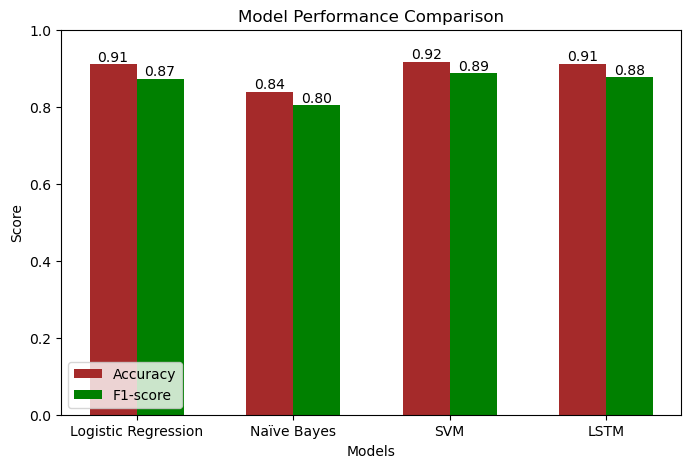

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'Naïve Bayes', 'SVM', 'LSTM']

# Accuracy and F1-score results from your models
accuracy_scores = [
    accuracy_score(y_test, y_pred_lr),  # Logistic Regression
    accuracy_score(y_test, y_pred_nb),  # Naïve Bayes
    accuracy_score(y_test, y_pred_svm),  # SVM
    accuracy_score(y_test, y_pred_lstm_updated)  # LSTM
]

f1_scores = [
    f1_score(y_test, y_pred_lr, average='macro'),
    f1_score(y_test, y_pred_nb, average='macro'),
    f1_score(y_test, y_pred_svm, average='macro'),
    f1_score(y_test, y_pred_lstm_updated, average='macro')
]

# Plotting the results
x = np.arange(len(models))
width = 0.3  # Bar width

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='brown')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-score', color='green')

# Labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show values on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)  # Keep scale between 0-1
plt.show()
